# Notebook for cleaning tags which will be used for synthetic query generation
 - Horribly messy
 - Would want to use a more relavent corpus to train Word2Vec on


In [308]:
import gensim.downloader as gensim_api
from torch.distributions import categorical
import pandas as pd
import numpy as np
from thefuzz import fuzz
from thefuzz import process
from gensim.models.word2vec import Word2Vec
import string
import matplotlib.pyplot as plt
import json

### First we load in and inspect the relavent data

In [3]:

b = pd.read_csv( 'books.csv' )
t = pd.read_csv( 'tags.csv' )
bt = pd.read_csv( 'book_tags.csv')

bt = bt.merge( t, on = 'tag_id' )
bt = bt.merge( b[[ 'goodreads_book_id', 'title']], on = 'goodreads_book_id' )


,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...
...,...,...,...,...,...
999907,675614,33057,7,ya-witches,"Book of Shadows (Sweep, #1)"
999908,675614,32624,6,witches-and-magic,"Book of Shadows (Sweep, #1)"
999909,675614,32612,6,witch-books,"Book of Shadows (Sweep, #1)"
999910,675614,32625,5,witches-and-warlocks,"Book of Shadows (Sweep, #1)"


In [4]:
tag_counts = bt.groupby( 'tag_name' ).tag_name.count().sort_values( ascending = False )
tag_counts.head( 40 )

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8239
ebook                8054
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
audio                6548
favourites           6422
novels               5665
own-it               5514
contemporary         5287
read-in-2015         5239
series               5080
e-book               4941
read-in-2016         4940
read-in-2014         4902
books                4818
adult-fiction        4775
e-books              4616
read-in-2013         4384
book-club            4365
audible              4346
fantasy              4259
romance              4251
aud

### Next we load in a Word2Vec model trained on gensim's text8 corpus
We will use this model to encode semantic information about the words into vectors. We will also need to determine which tags the model cannot convert to vectors

In [6]:
corpus = gensim_api.load('text8')
model = Word2Vec(corpus)

In [160]:
model.wv.most_similar(['adventure'])

[('fantasy', 0.7598863244056702),
 ('animated', 0.7530806660652161),
 ('anime', 0.7434439659118652),
 ('digimon', 0.7391576766967773),
 ('cartoon', 0.7252446413040161),
 ('themed', 0.7120233178138733),
 ('gurps', 0.7080823183059692),
 ('capcom', 0.7078747749328613),
 ('machinima', 0.7063214778900146),
 ('horror', 0.7037951946258545)]

In [7]:
def collect_error_words(tag_list):
    errors = []
    for tag in tag_list:
        for word in tag.split('-'):
            try:
                model.wv[word]
            except:
                errors.append(word)
    return errors
            

In [111]:
tag_list = bt.tag_name.unique()
error_words = collect_error_words(tag_list)
error_words = list(set(error_words)) # remove duplicates
print(error_words)

['', 'giveaways', 'taita', 'fabulist', 'hulks', 'goolrick', 'جوزيه', 'nesbo', 'muchamore', 'mistry', 'virago', 'dprk', 'inferring', 'pictur', 'moma', 'tmi', 'andika', 'bildbände', 'efaw', 'books_i_own', 'brokaw', 'doughty', 'американска', 'rheta', 'spirtitual', 'clásicos', 'wanna2read', 'lif', 'plays_to_read', 'celine', 'reisz', 'espanhola', 'كفاحي', 'anais', 'پارسی', 'جوستاين', 'piggle', 'vsauce', 'favourit', 'razy', 'robopocalypse', 'hoopla', '021614', 'poezija', 'espanola', 'recipies', 'sociologia', 'lgbtqia', 'craftmanship', 'bushrangers', '3araby', 'wonderous', 'crpl', 'heaberlin', 'Класика', 'ภา', 'follet', 'talentontwikkeling', 'السجون', 'engllish', 'delinsky', 'art_history', 'zakaria', '1970s', 'renard', 'herzagovina', 'divakaruni', 'acpl', 'soome', 'ضباط', 'doawk', 'زيدان', 'poemas', 'kitaplarım', 'classique', 'zoeken', 'atw80books', '258', 'first_ten', 'kohta', 'chik', 'koomson', 'يومية', 'الفلسطينية', 'Η', 'عندي', 'biblioteczka', '2002', 'witchy', 'macondo', 'romig', 'castee

In [152]:
tag_list = bt.tag_name.unique()
'sci-fi' in tag_list

True

Looking through the words that the Word2Vec model failed to parse, the most common error words seem to be in a different language, numbers, or missplellings and additionally some empty strings. Let's try and remove some of the erroneous words.

In [112]:
#filters(word) = bool x, where x = true iff it passes the checks in the body of filters
def filters(word):
    if len(word) == 0 or any([letter not in string.ascii_letters for letter in word]):
        return False
    return True

In [113]:
reduced_tag_list_1 = list(filter(lambda word: filters(word), error_words))
print(reduced_tag_list_1)

['giveaways', 'taita', 'fabulist', 'hulks', 'goolrick', 'nesbo', 'muchamore', 'mistry', 'virago', 'dprk', 'inferring', 'pictur', 'moma', 'tmi', 'andika', 'efaw', 'brokaw', 'doughty', 'rheta', 'spirtitual', 'lif', 'celine', 'reisz', 'espanhola', 'anais', 'piggle', 'vsauce', 'favourit', 'razy', 'robopocalypse', 'hoopla', 'poezija', 'espanola', 'recipies', 'sociologia', 'lgbtqia', 'craftmanship', 'bushrangers', 'wonderous', 'crpl', 'heaberlin', 'follet', 'talentontwikkeling', 'engllish', 'delinsky', 'zakaria', 'renard', 'herzagovina', 'divakaruni', 'acpl', 'soome', 'doawk', 'poemas', 'classique', 'zoeken', 'kohta', 'chik', 'koomson', 'biblioteczka', 'witchy', 'macondo', 'romig', 'casteel', 'nyl', 'religon', 'gtd', 'zooey', 'maclary', 'angstrom', 'infantil', 'ellroy', 'grandmothers', 'sarjakuva', 'tweens', 'counterfeiters', 'baldacci', 'degrasse', 'kazune', 'reber', 'actio', 'breezy', 'bree', 'boun', 'blackstock', 'lyzarein', 'aravind', 'angelini', 'zoey', 'tripathi', 'destra', 'sakarya', 

In [147]:
'sci' in reduced_tag_list_1

False

##### Still a long way to go :( 

We see that many of the words in here are almost words we would expect to see handled by a Word2Vec model trained on the English Language. And even if we the words are not English, we could reasonably infer the meaning behind similar languages like spanish or french. Lets use a form of fuzzy lookup in the vocabulary of our Word2Vec model to check if we can't handle a few more words!

In [49]:
# an example of fuzzy word similarity. where we have the similarity score for all our choices. 
#From this we can guess at good threshold values 
process.extract('helloo',['hello', '_hello','he;;oo','heaaoo'])

[('hello', 91), ('_hello', 83), ('he;;oo', 69), ('heaaoo', 67)]

In [128]:
def _fuzzy_filter_map(word,vocab):
    modified_vocab = list(filter(lambda v_word : (len(v_word) in range(len(word)-1,len(word)+1)),vocab))
    return process.extractOne(word,modified_vocab)

#returns dict wher dict[word] -> (corrected_word, score)
def FuzzyFilterAndSave(word_list, vocab):
    word_correction_dict = {}
    word_list = list(set(word_list))
    word_list = list(map(lambda word: ( word, _fuzzy_filter_map(word, vocab) ), word_list ))
    return(dict(word_list))

In [231]:
corrected_word_dict = FuzzyFilterAndSave(reduced_tag_list_1, model.wv.key_to_index.keys())
corrected_word_dict

{'giveaways': ('sideways', 71),
 'cfd': ('cf', 90),
 'asli': ('ali', 86),
 'popscience': ('conscience', 80),
 'alafair': ('affair', 77),
 'albee': ('alene', 80),
 'kristan': ('tristan', 86),
 'taita': ('tata', 89),
 'carle': ('care', 89),
 'sifi': ('sufi', 75),
 'fabulist': ('paulist', 80),
 'fantasyscifi': ('fantastical', 61),
 'kemmerer': ('kammerer', 88),
 'veganing': ('meaning', 80),
 'sleuths': ('islets', 77),
 'hulks': ('hulk', 89),
 'bookself': ('loosely', 67),
 'metaandhumor': ('metamorphic', 61),
 'englisch': ('english', 93),
 'goolrick': ('goodrich', 75),
 'stepehen': ('stephen', 93),
 'nesbo': ('news', 67),
 'antropologia': ('anthropology', 83),
 'moja': ('moa', 86),
 'ellie': ('elie', 89),
 'muchamore': ('muhammed', 71),
 'kotimainen': ('ilmarinen', 74),
 'uncookbooks': ('sourcebook', 57),
 'rdg': ('rd', 90),
 'hqs': ('hq', 90),
 'ayaan': ('aryan', 80),
 'jantan': ('ajanta', 83),
 'saramago': ('aramaic', 67),
 'goodreadss': ('goodfellas', 70),
 'holmsian': ('holzman', 80),


In [230]:
len(reduced_tag_list_1)

4439

In [255]:
#del corrected_word_dict['asddddddddddddddddddddddddddddd'] weirdness

In [305]:
# correct_words = []
# for key in corrected_word_dict:
#     value = corrected_word_dict[key]
#     if not(value == None or value[1] < 90):
#         correct_words.append(key)

In [292]:
len(correct_words)

880

### lets check our general level of confidance

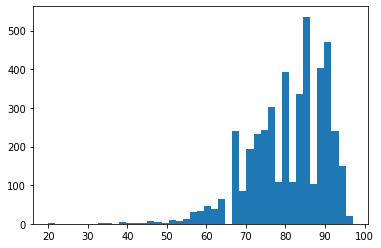

In [302]:
confidence_hist = []
for item in corrected_word_dict.values():
    confidence_hist.append(item[1])
    
plt.hist(confidence_hist, bins='auto')
print("")

### Now we update our error word list to only the words with a lower than 90 percent confidence

In [223]:
reduced_tag_list_2 = list(filter(lambda x: corrected_word_dict[x][1] > 90, reduced_tag_list_1[0:10]))
reduced_tag_list_2

['mistry', 'virago']

In [304]:
print(f'out of {len(error_words)} initially rejected tag words, we recovered {np.sum(np.asarray(confidence_hist)>90)}')

out of 6452 initially rejected tag words, we recovered 660


In [ ]:
bt.loc[ bt['count'] < 0, 'count'] = 0

In [265]:
def rowFilter(row):
    tag = row['tag_name']
    tag_words = tag.split('-')
    return int(any([(word in error_words and word not in correct_words) for word in tag_words]))
good_tag_mask = bt.apply (lambda row: rowFilter(row), axis=1)

In [327]:
def removeNullEntries(row):
    return int((len(row) == 0))
good_tag_mask = bt.apply ((lambda row: removeNullEntries(row)), axis=1)

### Finally, we get rid of entries with bad tags to get a cleaned dataframe

In [303]:
cleaned_bt = bt[good_tag_mask == 0]

cleaned_bt

,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...
...,...,...,...,...,...
999907,675614,33057,7,ya-witches,"Book of Shadows (Sweep, #1)"
999908,675614,32624,6,witches-and-magic,"Book of Shadows (Sweep, #1)"
999909,675614,32612,6,witch-books,"Book of Shadows (Sweep, #1)"
999910,675614,32625,5,witches-and-warlocks,"Book of Shadows (Sweep, #1)"


### Save our results


In [309]:
with open("dict.json", "w") as outfile:
    json.dump(corrected_word_dict, outfile)
    
cleaned_bt.to_csv('./cleaned_books_and_tags')